In [19]:
import numpy as np
import torch
import torch.nn as nn
from core import VAE,RBFNN,VAE_RBF,utils,riemannian_metric,manifolds
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

# Download and preprocess data

In [14]:
# # MNIST Dataset transformation
# mnist_transform = transforms.Compose([
#     transforms.ToTensor(), # Converts to [0, 1] interval
#     transforms.Lambda(lambda x: torch.flatten(x)) # Flattens the image to a 1D vector
# ])

# # dataset class to efficiently extract the relevant labels and not make a copy of the entire dataset
# class FilteredMNIST(Dataset):
#     def __init__(self, mnist_dataset, labels):
#         # Extract only the data with the specified labels
#         self.data = [(img, label) for img, label in mnist_dataset if label in labels]
#         self.imgs = [img for img, label in self.data]
#         self.targets = [label for img, label in self.data]

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx]


# # Download and load the MNIST dataset (if taking too long, cancel and try again it will worky)
# full_train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=mnist_transform, download=True)
# print("Original size of the dataset: ", len(full_train_dataset))
# filtered_labels = [1,2,3,4]
# print("Filtered labels: ", filtered_labels)
# train_dataset = FilteredMNIST(full_train_dataset, filtered_labels)
# print("New size of the dataset: ", len(train_dataset))

# batch_size = 256
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)



# MNIST Dataset transformation
fashionmnist_transform = transforms.Compose([
    transforms.ToTensor(), # Converts to [0, 1] interval
    transforms.Lambda(lambda x: torch.flatten(x)) # Flattens the image to a 1D vector
])

# dataset class to efficiently extract the relevant labels and not make a copy of the entire dataset
class FilteredMNIST(Dataset):
    def __init__(self, mnist_dataset, labels):
        # Extract only the data with the specified labels
        self.data = [(img, label) for img, label in mnist_dataset if label in labels]
        self.imgs = [img for img, label in self.data]
        self.targets = [label for img, label in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# Download and load the MNIST dataset (if taking too long, cancel and try again it will worky)
full_train_dataset = datasets.FashionMNIST(root='fashionmnist_data', train=True, transform=fashionmnist_transform, download=True)
print("Original size of the dataset: ", len(full_train_dataset))
filtered_labels = [0,1,7]
print("Filtered labels: ", filtered_labels)
train_dataset = FilteredMNIST(full_train_dataset, filtered_labels)
print("New size of the dataset: ", len(train_dataset))

batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)

Original size of the dataset:  60000
Filtered labels:  [0, 1, 7]
New size of the dataset:  18000


# Load saved model

In [15]:
# load the saved model
input_dim = train_dataset[0][0].shape[-1]
hidden_dims = [64, 32]
latent_dim = 2
hidden_activation = nn.Tanh()
encoder_output_mu_activation=nn.Identity()
encoder_output_logvar_activation=nn.Softplus()
decoder_output_mu_activation=nn.Sigmoid()
decoder_output_logvar_activation=nn.Softplus()

model_VAE = VAE.VAE(input_dim = input_dim, 
                hidden_dims = hidden_dims,
                latent_dim = latent_dim, 
                hidden_activation=hidden_activation, 
                encoder_output_mu_activation=encoder_output_mu_activation,
                encoder_output_logvar_activation=encoder_output_logvar_activation,
                decoder_output_mu_activation=decoder_output_mu_activation,
                decoder_output_logvar_activation=decoder_output_logvar_activation)

# create RBF network
k_rbf = 64
a = 2
zeta_rbf = 1e-6
model_rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

# create VAE-RBF model
model_VAE_RBF = VAE_RBF.VAE_RBF(model_VAE,model_rbfnn)

model_VAE_RBF.load_state_dict(torch.load('torch_models/VAE_RBFNN_fashionmnist.pt'))

<All keys matched successfully>

# Encode and decode the whole dataset

In [16]:
# encode and decode the data and store the outputs of the model
# computed on the whole dataset
latent_means_list = []
latent_logvars_list = []
latent_z = []
output_means_list = []
output_logvars_list = []
labels_list = []

with torch.no_grad():  
    for imgs, labels_ in train_loader: 
        mu_x, log_var_x, z_enc, mu_z, log_var_z = model_VAE_RBF.VAE(imgs)
        z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
        latent_means_list.append(mu_z)
        latent_logvars_list.append(log_var_z)
        latent_z.append(z_rep)
        output_means_list.append(mu_x)
        output_logvars_list.append(log_var_x)
        labels_list.append(labels_)

# Now we concatenate the list to form a single Tensor
latent_means = torch.cat(latent_means_list, dim=0)
latent_logvars = torch.cat(latent_logvars_list, dim=0)
latent_z = torch.cat(latent_z, dim=0)
output_means = torch.cat(output_means_list, dim=0)
output_logvars = torch.cat(output_logvars_list, dim=0)
labels = torch.cat(labels_list, dim=0)

### Construct the manifold

In [20]:
latent_means_np = latent_means.detach().numpy()

# The G_mode_parameters is used by the manifold class to compute the metric tensor
G_model_parameters = {'name': 'generator'}
w_counter = 0
b_counter = 0
for name, param in model_VAE_RBF.VAE.named_parameters():
    if ('dec' or 'mu_dec') in name:
        if 'weight' in name:
            key_name = 'W' + str(w_counter)
            G_model_parameters[key_name] = param.detach().numpy()
            w_counter += 1
        elif 'bias' in name:
            key_name = 'b' + str(b_counter)
            G_model_parameters[key_name] = param.detach().numpy().reshape(-1, 1)
            b_counter += 1

G_model_parameters['activation_fun_hidden'] = str(hidden_activation).lower()  # Get the name of activFun e.g. Tanh() -> tanh
G_model_parameters['activation_fun_output'] = str(decoder_output_mu_activation).lower()
G_model_parameters['Wrbf'] = model_VAE_RBF.RBF.W_rbf.detach().numpy()  # The weights for the RBFs (D x K)
G_model_parameters['Crbf'] = model_VAE_RBF.RBF.centers_rbf.detach().numpy()  # The centers for the RBFs (K x d)
G_model_parameters['Grbf'] = model_VAE_RBF.RBF.lambdas_k.detach().numpy()  # * np.ones((K_rbf, 1))  # The precision for the RBFs (K x 1)
G_model_parameters['zeta'] = zeta_rbf  # A small value to prevent division by 0
G_model_parameters['beta'] = 1.0  # This scaling parameter of the metric is updated later

# Construct the manifold
print("Constructing the manifold...")
manifold_latent = manifolds.MlpMeanInvRbfVar(G_model_parameters)
print("Computing the metric tensor...")
metric_tensor = manifold_latent.metric_tensor(latent_means_np.T)

# Rescale the metric such that the maximum measure on the data to be 1
beta_rbf = 1 / (np.sqrt(np.linalg.det(metric_tensor).max()))
G_model_parameters['beta'] = beta_rbf ** (2 / latent_dim)  # Rescale the pull-back metric
z1min_latent, z2min_latent = latent_means_np.min(0) - 0.5
z1max_latent, z2max_latent = latent_means_np.max(0) + 0.

Constructing the manifold...
Computing the metric tensor...


# Perform the random walk

In [26]:
starting_z = np.array([[0.],[0.]])
step_size = 0.1
N_steps = 10000
Z_riemannian = np.zeros((N_steps, starting_z.shape[0]))
Z_euclidian = np.zeros((N_steps, starting_z.shape[0]))

z_riemannian = starting_z
z_euclidian = starting_z
for n in range(N_steps):
    # get metric tensor M(z) and compute eigendecomposition
    M_z = manifold_latent.metric_tensor(z_riemannian).squeeze(0)
    L,U = np.linalg.eigh(M_z)
    
    # sample random vector
    epsilon = np.random.normal(0,1,size=(latent_dim,1))
    
    # compute v=UL^{1/2} @ epsilon
    L_inv_sqrt = np.diag(1/np.sqrt(L))
    
    v = U @ L_inv_sqrt @ epsilon

    # update z
    z_riemannian = (z_riemannian + step_size*v)
    # normalize the step in the euclidian space 
    #z_euclidian = (z_euclidian + step_size*(epsilon/np.linalg.norm(epsilon)))
    z_euclidian = (z_euclidian + step_size*epsilon)


    Z_riemannian[n,:] = z_riemannian.T
    Z_euclidian[n,:] = z_euclidian.T

# Plot the random walk on the manifold

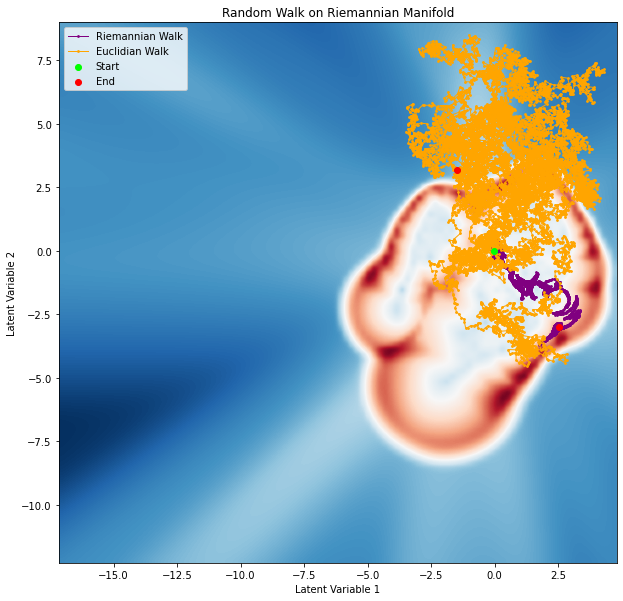

In [25]:
z1min_walk_riem, z2min_walk_riem = Z_riemannian.min(0) - 0.5
z1max_walk_riem, z2max_walk_riem = Z_riemannian.max(0) + 0.5

z1min_walk_eucl, z2min_walk_eucl = Z_euclidian.min(0) - 0.5
z1max_walk_eucl, z2max_walk_eucl = Z_euclidian.max(0) + 0.5

z1min_latent = min(z1min_latent, z1min_walk_riem, z1min_walk_eucl)
z1max_latent = max(z1max_latent, z1max_walk_riem, z1max_walk_eucl)
z2min_latent = min(z2min_latent, z2min_walk_riem, z2min_walk_eucl)
z2max_latent = max(z2max_latent, z2max_walk_riem, z2max_walk_eucl)

plt.figure(figsize=(10,10))
# plot the measure
utils.plot_measure(manifold_latent, np.linspace(z1min_latent, z1max_latent, 100), np.linspace(z2min_latent, z2max_latent, 100))

# plot the random walk on top
plt.plot(Z_riemannian[:, 0], Z_riemannian[:, 1], '-o',c='purple', zorder=1,markersize=1.75,linewidth=1,label='Riemannian Walk')

plt.plot(Z_euclidian[:, 0], Z_euclidian[:, 1], '-o',c='orange', zorder=1,markersize=1.75,linewidth=1,label='Euclidian Walk')

# highlight the start and end points
plt.scatter(Z_riemannian[0, 0], Z_riemannian[0, 1], c='lime',zorder=2,label='Start')
plt.scatter(Z_riemannian[-1, 0], Z_riemannian[-1, 1], c='red',zorder=3,label='End')
plt.scatter(Z_euclidian[-1, 0], Z_euclidian[-1, 1], c='red',zorder=3)

# Adding labels and legend
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Random Walk on Riemannian Manifold')
plt.legend()
plt.show()

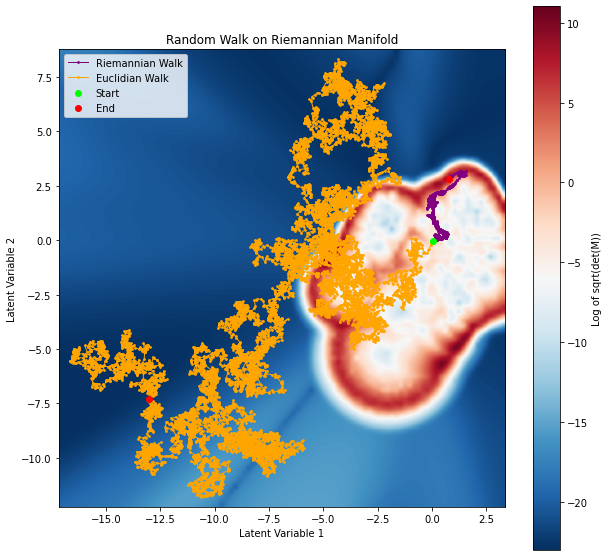

In [23]:
z1min_walk_riem, z2min_walk_riem = Z_riemannian.min(0) - 0.5
z1max_walk_riem, z2max_walk_riem = Z_riemannian.max(0) + 0.5

z1min_walk_eucl, z2min_walk_eucl = Z_euclidian.min(0) - 0.5
z1max_walk_eucl, z2max_walk_eucl = Z_euclidian.max(0) + 0.5

z1min_latent = min(z1min_latent, z1min_walk_riem, z1min_walk_eucl)
z1max_latent = max(z1max_latent, z1max_walk_riem, z1max_walk_eucl)
z2min_latent = min(z2min_latent, z2min_walk_riem, z2min_walk_eucl)
z2max_latent = max(z2max_latent, z2max_walk_riem, z2max_walk_eucl)

plt.figure(figsize=(10,10))
# plot the measure
metric = riemannian_metric.Riemannian_metric(model_VAE_RBF)
metric.plot_MZ(np.linspace(z1min_latent, z1max_latent, 100), np.linspace(z2min_latent, z2max_latent, 100),vae_rbfn=True)


# plot the random walk on top
plt.plot(Z_riemannian[:, 0], Z_riemannian[:, 1], '-o',c='purple', zorder=1,markersize=1.75,linewidth=1,label='Riemannian Walk')

plt.plot(Z_euclidian[:, 0], Z_euclidian[:, 1], '-o',c='orange', zorder=1,markersize=1.75,linewidth=1,label='Euclidian Walk')

# highlight the start and end points
plt.scatter(Z_riemannian[0, 0], Z_riemannian[0, 1], c='lime',zorder=2,label='Start')
plt.scatter(Z_riemannian[-1, 0], Z_riemannian[-1, 1], c='red',zorder=3,label='End')
plt.scatter(Z_euclidian[-1, 0], Z_euclidian[-1, 1], c='red',zorder=3)

# Adding labels and legend
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Random Walk on Riemannian Manifold')
plt.legend()
plt.show()

# Plot some of the samples 

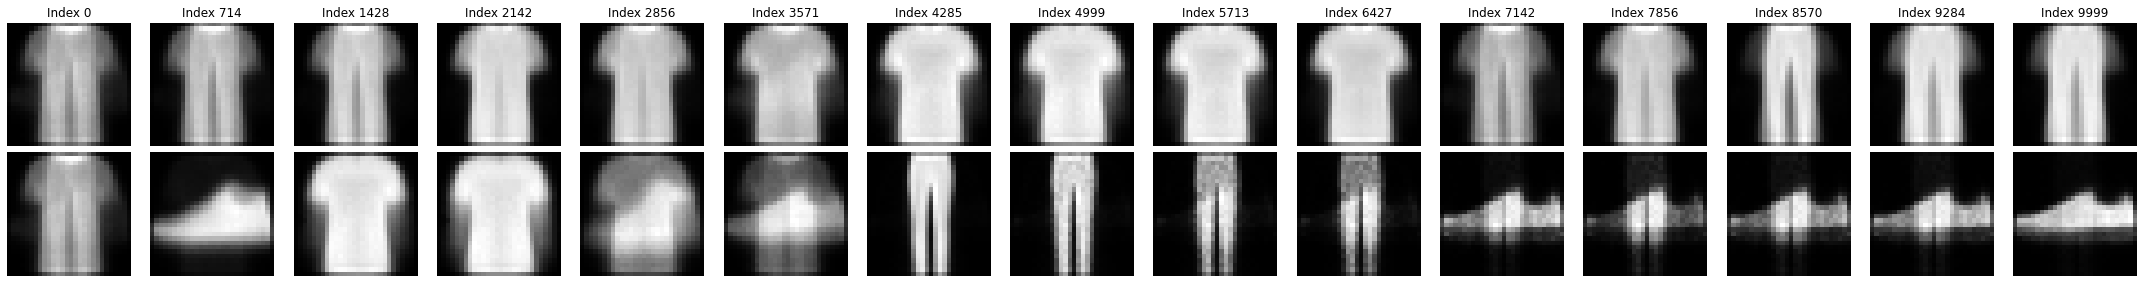

In [54]:
def generate_data_from_latent(model_VAE, latent_points):
    mu, _ = model_VAE.decode(latent_points)
    mu = mu.cpu().numpy()
    #threshold = 0.5
    #binary_image = (mu > threshold).astype(np.float32)
    return mu

    
with torch.no_grad():
    num_samples_to_generate = 15

    indices = np.linspace(0,len(Z_riemannian)-1,num_samples_to_generate,dtype=int)
    
    selected_z_riemmanian = Z_riemannian[indices]
    z_riemannian = torch.from_numpy(selected_z_riemmanian.astype(np.float32))
    generated_data_var_riemannian = generate_data_from_latent(model_VAE_RBF.VAE, z_riemannian)


    selected_z_euclidian = Z_euclidian[indices]
    z_euclidian = torch.from_numpy(selected_z_euclidian.astype(np.float32))
    generated_data_var_euclidian = generate_data_from_latent(model_VAE_RBF.VAE, z_euclidian)

    generated_data_var_riemannian = generated_data_var_riemannian.reshape(num_samples_to_generate, 28, 28)
    generated_data_var_euclidian = generated_data_var_euclidian.reshape(num_samples_to_generate, 28, 28)

    num_samples_to_generate = len(indices)
    fig, axs = plt.subplots(2, num_samples_to_generate, figsize=(num_samples_to_generate * 2, 4))

    for i, idx in enumerate(indices):
        # Plot Riemannian samples in the top row
        axs[0, i].imshow(generated_data_var_riemannian[i], cmap='gray')
        axs[0, i].title.set_text(f'Index {idx}')
        axs[0, i].axis('off')  # Turn off axis

        # Plot Euclidean samples in the bottom row
        axs[1, i].imshow(generated_data_var_euclidian[i], cmap='gray')
        axs[1, i].axis('off')  # Turn off axis

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
